# Optimising (further?) a Typewriter

I read this [very interesting article](https://hardmath123.github.io/crown-typewriter.html) a few days ago. I found this very interesting, and I wanted to see If I could 

* Reproduce the result
* Try a constraints solver for this issue
* Maybe devise another algorithm

So let's start with the beginning, and load the data. Wa want to use the same dataset to compare the results!

## Loading the data


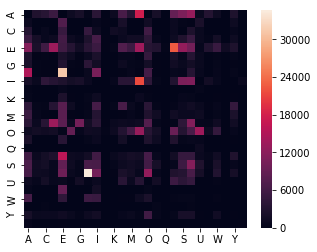

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

alphabet= string.ascii_uppercase
infile = open('digraphs.txt', 'r')
digraph_matrix=np.empty([len(alphabet), len(alphabet)])
index=0
for line in infile:
    line = line.replace('\n', '').replace('{', '').replace('},', '').replace('}', '').replace(' ', '')
    digraph_matrix[index]=line.split(',')  
    index+=1
infile.close()

df = pd.DataFrame(digraph_matrix, index=list(alphabet),columns=list(alphabet))
fig, ax = plt.subplots(figsize=(5,4))         # Sample figsize in inches

p1 = sns.heatmap(df)
#Seems ok to me

# Cleaning the data
The result is ok, but two things could be better:

* We will use this matrix to calculate the cost of movement. So the diagonal might as well be zero, cause it costs us nothing
* From the same line of thinking, we don't care about A-->B or B-->A. We might as well sum to the half matrix.

In [5]:
summed_digraph=np.add(digraph_matrix,digraph_matrix.transpose())
diag_digraph=np.tril(summed_digraph)

### Cost Function
Let's write the cost function, and check that we fit with the article conclusions

In [6]:
def distance_in_string(a,b,string):
    #index because we want to know if it is not found
    return abs(string.index(a)-string.index(b))


def test_permutation(string_permutation):
    distance_matrix=np.empty([len(alphabet), len(alphabet)])
    for index_1,letter_1 in enumerate(alphabet):
        for index_2,letter_2 in enumerate(alphabet):
            distance_matrix[index_1][index_2]=distance_in_string(letter_1,letter_2,string_permutation)
    score_matrix=np.multiply(distance_matrix, diag_digraph)
    return score_matrix.sum()

test_permutation("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
#It's OK with the source! 

9630941.0

### Genetic method

Ok so let's implement a genetic algorihm:

* Start from random permutation
* Try 10 random swap
* Chooses the best 

In [5]:
import random 

def random_permutation():
    alphabet_list= list(string.ascii_uppercase)
    random.shuffle(alphabet_list)
    return ''.join(alphabet_list)

def random_swap(string):
    list_string=list(string)
    indexes=random.sample(range(0,len(string)), 2)
    save=list_string[indexes[1]]
    list_string[indexes[1]]=list_string[indexes[0]]
    list_string[indexes[0]]=save
    return ''.join(list_string)

def evolve_string(string,number_test):
    best_performance=test_permutation(string)
    best_outsider=string
    for i in range(number_test):
        outsider=random_swap(string)
        outsider_score=test_permutation(outsider)
        if outsider_score<best_performance:
            best_outsider=outsider
            best_performance=outsider_score
    return best_outsider
    
def genetic_force(seed_size,number_test,stop_cutoff):
    #generate seed
    family= [random_permutation() for x in range(seed_size)]
    stop_counter=0
    while stop_counter<stop_cutoff:
        old_family=family.copy()
        for index, value in enumerate(family):
            family[index]=evolve_string(value,number_test)
        if old_family==family:
            stop_counter+=1
        else:
            stop_counter=0
        score=[test_permutation(x) for x in family]
        arg=np.argsort(score)[0]
    score=[test_permutation(x) for x in family]
    arg=np.argsort(score)[0]
    return score[arg],family[arg]
    
#It might take a while!
genetic_force(100,50,5)

(5499341.0, 'QJXPBYFMULORSETHAINDCWGVKZ')

### Constraint-based solving

Ok so now, let's try a constraint based method. We we use google or-tools

In [ ]:
from ortools.sat.python import cp_model

#Need to update my mac to have the right version